In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    channel_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         3104      
_________________________________________________________________
flatten (Flatten)            (None, 512000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 512000)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                8192016   
Total params: 8,195,248
Trainable params: 8,195,248
Non-trainable params: 0
___________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 32)          3104      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 32)          3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 32)          3104      
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 32)          3104      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3935 - acc: 0.2156
Epoch 00001: val_loss improved from inf to 1.84597, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_4_conv_checkpoint/001-1.8460.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.3935 - acc: 0.2156 - val_loss: 1.8460 - val_acc: 0.4009
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7798 - acc: 0.4215
Epoch 00002: val_loss improved from 1.84597 to 1.62328, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_4_conv_checkpoint/002-1.6233.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.7797 - acc: 0.4215 - val_loss: 1.6233 - val_acc: 0.4885
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6170 - acc: 0.4767
Epoch 00003: val_loss improved from

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7458 - acc: 0.7711
Epoch 00022: val_loss improved from 0.86059 to 0.85399, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_4_conv_checkpoint/022-0.8540.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.7457 - acc: 0.7711 - val_loss: 0.8540 - val_acc: 0.7501
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7306 - acc: 0.7769
Epoch 00023: val_loss improved from 0.85399 to 0.84674, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_4_conv_checkpoint/023-0.8467.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.7305 - acc: 0.7769 - val_loss: 0.8467 - val_acc: 0.7536
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7092 - acc: 0.7813
Epoch 00024: val_loss improved from 0.84674 to 0.83537, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_07

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4881 - acc: 0.8434
Epoch 00047: val_loss did not improve from 0.74766
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.4881 - acc: 0.8434 - val_loss: 0.7552 - val_acc: 0.7901
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4849 - acc: 0.8432
Epoch 00048: val_loss did not improve from 0.74766
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.4849 - acc: 0.8432 - val_loss: 0.7493 - val_acc: 0.7866
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4907 - acc: 0.8439
Epoch 00049: val_loss did not improve from 0.74766
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.4906 - acc: 0.8439 - val_loss: 0.7524 - val_acc: 0.7857
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4742 - acc: 0.8469
Epoch 00050: val_loss improved from 0.74766 to 0.73529, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.3910 - acc: 0.8720
Epoch 00075: val_loss did not improve from 0.72521
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3909 - acc: 0.8721 - val_loss: 0.7356 - val_acc: 0.8020
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3895 - acc: 0.8722
Epoch 00076: val_loss improved from 0.72521 to 0.70906, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_4_conv_checkpoint/076-0.7091.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3895 - acc: 0.8722 - val_loss: 0.7091 - val_acc: 0.8057
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3855 - acc: 0.8720
Epoch 00077: val_loss did not improve from 0.70906
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3855 - acc: 0.8721 - val_loss: 0.7393 - val_acc: 0.8057
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3408 - acc: 0.8891
Epoch 00104: val_loss did not improve from 0.70881
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3407 - acc: 0.8891 - val_loss: 0.7393 - val_acc: 0.8053
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3358 - acc: 0.8885
Epoch 00105: val_loss did not improve from 0.70881
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3358 - acc: 0.8885 - val_loss: 0.7144 - val_acc: 0.8127
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3343 - acc: 0.8892
Epoch 00106: val_loss did not improve from 0.70881
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3343 - acc: 0.8892 - val_loss: 0.7320 - val_acc: 0.8118
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3358 - acc: 0.8888
Epoch 00107: val_loss did not improve from 0.70881
36805/36805 [=======

Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2779 - acc: 0.9074
Epoch 00163: val_loss did not improve from 0.68299
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2783 - acc: 0.9074 - val_loss: 0.7089 - val_acc: 0.8272
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2847 - acc: 0.9065
Epoch 00164: val_loss did not improve from 0.68299
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2846 - acc: 0.9065 - val_loss: 0.6971 - val_acc: 0.8332
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2795 - acc: 0.9082
Epoch 00165: val_loss did not improve from 0.68299
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2794 - acc: 0.9082 - val_loss: 0.7441 - val_acc: 0.8246
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2826 - acc: 0.9054
Epoch 00166: val_loss did not improve from 0.68299
36805/36805 [=======

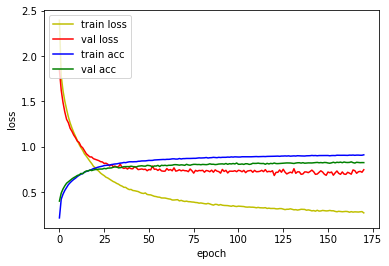

4815/4815 [==============================] - 2s 511us/sample - loss: 0.8153 - acc: 0.7892
Loss: 0.8152669871088624 Accuracy: 0.7892004

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4865 - acc: 0.1843
Epoch 00001: val_loss improved from inf to 1.94583, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_5_conv_checkpoint/001-1.9458.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 2.4864 - acc: 0.1843 - val_loss: 1.9458 - val_acc: 0.3755
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8325 - acc: 0.3976
Epoch 00002: val_loss improved from 1.94583 to 1.52103, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_5_conv_checkpoint/002-1.5210.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.8325 - acc: 0.3977 - val_loss: 1.5210 - val_acc: 0.5257
Epoch 3/500
36800/36805 [==================

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4314 - acc: 0.8640
Epoch 00047: val_loss did not improve from 0.55696
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.4314 - acc: 0.8640 - val_loss: 0.5656 - val_acc: 0.8500
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4254 - acc: 0.8657
Epoch 00048: val_loss did not improve from 0.55696
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.4254 - acc: 0.8657 - val_loss: 0.5757 - val_acc: 0.8493
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4303 - acc: 0.8648
Epoch 00049: val_loss improved from 0.55696 to 0.55261, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_5_conv_checkpoint/049-0.5526.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.4303 - acc: 0.8648 - val_loss: 0.5526 - val_acc: 0.8535
Epoch 50/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.3364 - acc: 0.8943
Epoch 00075: val_loss did not improve from 0.52496
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3364 - acc: 0.8943 - val_loss: 0.5297 - val_acc: 0.8628
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3322 - acc: 0.8929
Epoch 00076: val_loss did not improve from 0.52496
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3322 - acc: 0.8929 - val_loss: 0.5593 - val_acc: 0.8628
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3366 - acc: 0.8919
Epoch 00077: val_loss did not improve from 0.52496
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3366 - acc: 0.8919 - val_loss: 0.5586 - val_acc: 0.8633
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3334 - acc: 0.8952
Epoch 00078: val_loss did not improve from 0.52496
36805/36805 [========================

Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2824 - acc: 0.9069
Epoch 00104: val_loss did not improve from 0.51993
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2824 - acc: 0.9069 - val_loss: 0.5489 - val_acc: 0.8721
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2872 - acc: 0.9056
Epoch 00105: val_loss did not improve from 0.51993
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2872 - acc: 0.9056 - val_loss: 0.5432 - val_acc: 0.8744
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2851 - acc: 0.9079
Epoch 00106: val_loss did not improve from 0.51993
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2851 - acc: 0.9079 - val_loss: 0.5494 - val_acc: 0.8682
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2791 - acc: 0.9095
Epoch 00107: val_loss did not improve from 0.51993
36805/36805 [=======

Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2516 - acc: 0.9173
Epoch 00133: val_loss did not improve from 0.51631
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2517 - acc: 0.9173 - val_loss: 0.5587 - val_acc: 0.8714
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2490 - acc: 0.9176
Epoch 00134: val_loss did not improve from 0.51631
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2489 - acc: 0.9176 - val_loss: 0.5276 - val_acc: 0.8737
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2486 - acc: 0.9181
Epoch 00135: val_loss did not improve from 0.51631
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.2486 - acc: 0.9181 - val_loss: 0.5221 - val_acc: 0.8717
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2484 - acc: 0.9184
Epoch 00136: val_loss did not improve from 0.51631
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.2108 - acc: 0.9302
Epoch 00191: val_loss did not improve from 0.49034
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2108 - acc: 0.9302 - val_loss: 0.5148 - val_acc: 0.8793
Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2065 - acc: 0.9322
Epoch 00192: val_loss did not improve from 0.49034
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.2064 - acc: 0.9322 - val_loss: 0.5356 - val_acc: 0.8866
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2104 - acc: 0.9305
Epoch 00193: val_loss did not improve from 0.49034
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2104 - acc: 0.9305 - val_loss: 0.5142 - val_acc: 0.8845
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2010 - acc: 0.9342
Epoch 00194: val_loss did not improve from 0.49034
36805/36805 [=====================

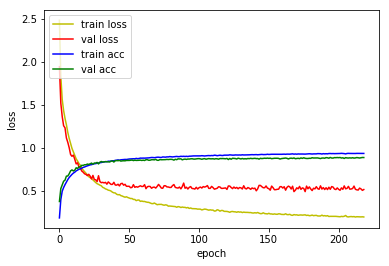

4815/4815 [==============================] - 3s 548us/sample - loss: 0.5928 - acc: 0.8480
Loss: 0.5928024519145922 Accuracy: 0.8479751

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6387 - acc: 0.1240
Epoch 00001: val_loss improved from inf to 2.34659, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_6_conv_checkpoint/001-2.3466.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.6386 - acc: 0.1240 - val_loss: 2.3466 - val_acc: 0.2660
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0488 - acc: 0.3254
Epoch 00002: val_loss improved from 2.34659 to 1.63222, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_6_conv_checkpoint/002-1.6322.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.0487 - acc: 0.3254 - val_loss: 1.6322 - val_acc: 0.4761
Epoch 3/500
36800/36805 [==================

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4691 - acc: 0.8585
Epoch 00047: val_loss improved from 0.39476 to 0.38690, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_6_conv_checkpoint/047-0.3869.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4690 - acc: 0.8584 - val_loss: 0.3869 - val_acc: 0.8977
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4707 - acc: 0.8585
Epoch 00048: val_loss improved from 0.38690 to 0.37999, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_6_conv_checkpoint/048-0.3800.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4707 - acc: 0.8585 - val_loss: 0.3800 - val_acc: 0.8938
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4530 - acc: 0.8641
Epoch 00049: val_loss did not improve from 0.37999
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.45

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3715 - acc: 0.8864
Epoch 00073: val_loss did not improve from 0.33359
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3714 - acc: 0.8864 - val_loss: 0.3458 - val_acc: 0.9096
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3609 - acc: 0.8890
Epoch 00074: val_loss improved from 0.33359 to 0.33113, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_6_conv_checkpoint/074-0.3311.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3610 - acc: 0.8890 - val_loss: 0.3311 - val_acc: 0.9143
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3643 - acc: 0.8890
Epoch 00075: val_loss did not improve from 0.33113
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3642 - acc: 0.8890 - val_loss: 0.3354 - val_acc: 0.9068
Epoch 76/500
36800/36805 [============================>.] -

Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3057 - acc: 0.9047
Epoch 00100: val_loss did not improve from 0.30203
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3057 - acc: 0.9047 - val_loss: 0.3036 - val_acc: 0.9199
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2998 - acc: 0.9058
Epoch 00101: val_loss did not improve from 0.30203
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2998 - acc: 0.9058 - val_loss: 0.3147 - val_acc: 0.9171
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3005 - acc: 0.9062
Epoch 00102: val_loss did not improve from 0.30203
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3004 - acc: 0.9062 - val_loss: 0.3054 - val_acc: 0.9189
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3013 - acc: 0.9054
Epoch 00103: val_loss did not improve from 0.30203
36805/36805 [=======

Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2572 - acc: 0.9177
Epoch 00128: val_loss did not improve from 0.27956
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2572 - acc: 0.9178 - val_loss: 0.2934 - val_acc: 0.9278
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2604 - acc: 0.9176
Epoch 00129: val_loss did not improve from 0.27956
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2604 - acc: 0.9176 - val_loss: 0.3011 - val_acc: 0.9262
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2631 - acc: 0.9170
Epoch 00130: val_loss did not improve from 0.27956
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2630 - acc: 0.9170 - val_loss: 0.2930 - val_acc: 0.9264
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2610 - acc: 0.9174
Epoch 00131: val_loss did not improve from 0.27956
36805/36805 [=======

Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2362 - acc: 0.9243
Epoch 00157: val_loss improved from 0.27610 to 0.27399, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_6_conv_checkpoint/157-0.2740.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2362 - acc: 0.9243 - val_loss: 0.2740 - val_acc: 0.9299
Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2210 - acc: 0.9285
Epoch 00158: val_loss did not improve from 0.27399
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2210 - acc: 0.9284 - val_loss: 0.2746 - val_acc: 0.9301
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2302 - acc: 0.9248
Epoch 00159: val_loss did not improve from 0.27399
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2302 - acc: 0.9248 - val_loss: 0.2845 - val_acc: 0.9285
Epoch 160/500
36800/36805 [============================>

Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2087 - acc: 0.9318
Epoch 00185: val_loss did not improve from 0.26846
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2087 - acc: 0.9318 - val_loss: 0.2716 - val_acc: 0.9315
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2016 - acc: 0.9326
Epoch 00186: val_loss did not improve from 0.26846
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2017 - acc: 0.9326 - val_loss: 0.2842 - val_acc: 0.9324
Epoch 187/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1960 - acc: 0.9356
Epoch 00187: val_loss did not improve from 0.26846
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1960 - acc: 0.9356 - val_loss: 0.2860 - val_acc: 0.9311
Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2049 - acc: 0.9326
Epoch 00188: val_loss did not improve from 0.26846
36805/36805 [=======

Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1684 - acc: 0.9446
Epoch 00244: val_loss did not improve from 0.26445
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1684 - acc: 0.9446 - val_loss: 0.2791 - val_acc: 0.9350
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1724 - acc: 0.9435
Epoch 00245: val_loss did not improve from 0.26445
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1725 - acc: 0.9434 - val_loss: 0.2991 - val_acc: 0.9313
Epoch 246/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1712 - acc: 0.9434
Epoch 00246: val_loss did not improve from 0.26445
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1711 - acc: 0.9434 - val_loss: 0.2778 - val_acc: 0.9348
Epoch 247/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1682 - acc: 0.9463
Epoch 00247: val_loss did not improve from 0.26445
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.1524 - acc: 0.9491
Epoch 00302: val_loss did not improve from 0.25716
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1524 - acc: 0.9491 - val_loss: 0.2733 - val_acc: 0.9390
Epoch 303/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1470 - acc: 0.9511
Epoch 00303: val_loss did not improve from 0.25716
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1470 - acc: 0.9511 - val_loss: 0.2790 - val_acc: 0.9373
Epoch 304/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1446 - acc: 0.9513
Epoch 00304: val_loss did not improve from 0.25716
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1446 - acc: 0.9513 - val_loss: 0.2825 - val_acc: 0.9399
Epoch 305/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1396 - acc: 0.9529
Epoch 00305: val_loss did not improve from 0.25716
36805/36805 [=====================

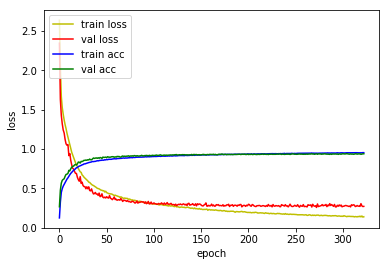

4815/4815 [==============================] - 3s 555us/sample - loss: 0.3019 - acc: 0.9209
Loss: 0.3019223801010247 Accuracy: 0.9208723

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7039 - acc: 0.0886
Epoch 00001: val_loss improved from inf to 2.53641, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_7_conv_checkpoint/001-2.5364.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 2.7039 - acc: 0.0885 - val_loss: 2.5364 - val_acc: 0.1798
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3065 - acc: 0.2388
Epoch 00002: val_loss improved from 2.53641 to 1.81648, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_7_conv_checkpoint/002-1.8165.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.3065 - acc: 0.2389 - val_loss: 1.8165 - val_acc: 0.4333
Epoch 3/500
36800/36805 [==================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7111 - acc: 0.7824
Epoch 00022: val_loss did not improve from 0.47699
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.7110 - acc: 0.7824 - val_loss: 0.4780 - val_acc: 0.8698
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6837 - acc: 0.7930
Epoch 00023: val_loss improved from 0.47699 to 0.46923, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_7_conv_checkpoint/023-0.4692.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.6837 - acc: 0.7930 - val_loss: 0.4692 - val_acc: 0.8696
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6542 - acc: 0.8024
Epoch 00024: val_loss improved from 0.46923 to 0.44642, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_7_conv_checkpoint/024-0.4464.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.65

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4181 - acc: 0.8724
Epoch 00047: val_loss did not improve from 0.25596
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4181 - acc: 0.8725 - val_loss: 0.2742 - val_acc: 0.9266
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4088 - acc: 0.8760
Epoch 00048: val_loss did not improve from 0.25596
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4088 - acc: 0.8760 - val_loss: 0.2960 - val_acc: 0.9192
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4111 - acc: 0.8721
Epoch 00049: val_loss did not improve from 0.25596
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4111 - acc: 0.8721 - val_loss: 0.2600 - val_acc: 0.9259
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3973 - acc: 0.8800
Epoch 00050: val_loss did not improve from 0.25596
36805/36805 [===========

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3061 - acc: 0.9042
Epoch 00073: val_loss did not improve from 0.20685
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3062 - acc: 0.9042 - val_loss: 0.2524 - val_acc: 0.9322
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3061 - acc: 0.9045
Epoch 00074: val_loss improved from 0.20685 to 0.20288, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_7_conv_checkpoint/074-0.2029.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3061 - acc: 0.9046 - val_loss: 0.2029 - val_acc: 0.9453
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3043 - acc: 0.9056
Epoch 00075: val_loss did not improve from 0.20288
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3043 - acc: 0.9056 - val_loss: 0.2073 - val_acc: 0.9420
Epoch 76/500
36800/36805 [============================>.] -

Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2033 - acc: 0.9350
Epoch 00129: val_loss did not improve from 0.17134
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2033 - acc: 0.9350 - val_loss: 0.1778 - val_acc: 0.9536
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2044 - acc: 0.9354
Epoch 00130: val_loss did not improve from 0.17134
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2044 - acc: 0.9354 - val_loss: 0.1886 - val_acc: 0.9469
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2027 - acc: 0.9354
Epoch 00131: val_loss did not improve from 0.17134
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2027 - acc: 0.9354 - val_loss: 0.1928 - val_acc: 0.9527
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1983 - acc: 0.9365
Epoch 00132: val_loss did not improve from 0.17134
36805/36805 [=======

Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1707 - acc: 0.9440
Epoch 00158: val_loss did not improve from 0.16761
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1707 - acc: 0.9440 - val_loss: 0.1928 - val_acc: 0.9511
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1771 - acc: 0.9417
Epoch 00159: val_loss did not improve from 0.16761
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1771 - acc: 0.9417 - val_loss: 0.1678 - val_acc: 0.9555
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1721 - acc: 0.9460
Epoch 00160: val_loss did not improve from 0.16761
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1721 - acc: 0.9460 - val_loss: 0.1758 - val_acc: 0.9581
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1690 - acc: 0.9451
Epoch 00161: val_loss did not improve from 0.16761
36805/36805 [=======

Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1455 - acc: 0.9514
Epoch 00188: val_loss did not improve from 0.16761
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1455 - acc: 0.9514 - val_loss: 0.1984 - val_acc: 0.9529
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1446 - acc: 0.9526
Epoch 00189: val_loss did not improve from 0.16761
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1446 - acc: 0.9526 - val_loss: 0.1754 - val_acc: 0.9553
Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1446 - acc: 0.9520
Epoch 00190: val_loss did not improve from 0.16761
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1446 - acc: 0.9520 - val_loss: 0.1766 - val_acc: 0.9562
Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1428 - acc: 0.9531
Epoch 00191: val_loss did not improve from 0.16761
36805/36805 [=======

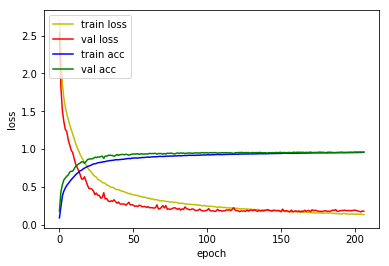

4815/4815 [==============================] - 3s 571us/sample - loss: 0.1951 - acc: 0.9427
Loss: 0.19514510566417054 Accuracy: 0.9426791

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7180 - acc: 0.0865
Epoch 00001: val_loss improved from inf to 2.62728, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_8_conv_checkpoint/001-2.6273.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.7180 - acc: 0.0865 - val_loss: 2.6273 - val_acc: 0.1363
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4570 - acc: 0.1927
Epoch 00002: val_loss improved from 2.62728 to 2.01774, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_8_conv_checkpoint/002-2.0177.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.4569 - acc: 0.1927 - val_loss: 2.0177 - val_acc: 0.3615
Epoch 3/500
36800/36805 [=================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6105 - acc: 0.8101
Epoch 00022: val_loss improved from 0.36132 to 0.34973, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_8_conv_checkpoint/022-0.3497.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.6104 - acc: 0.8101 - val_loss: 0.3497 - val_acc: 0.9022
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5826 - acc: 0.8198
Epoch 00023: val_loss improved from 0.34973 to 0.33598, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_8_conv_checkpoint/023-0.3360.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.5827 - acc: 0.8198 - val_loss: 0.3360 - val_acc: 0.9078
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5667 - acc: 0.8223
Epoch 00024: val_loss improved from 0.33598 to 0.32297, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_07

36800/36805 [============================>.] - ETA: 0s - loss: 0.2354 - acc: 0.9264
Epoch 00071: val_loss did not improve from 0.14030
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2354 - acc: 0.9264 - val_loss: 0.1491 - val_acc: 0.9543
Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2310 - acc: 0.9284
Epoch 00072: val_loss did not improve from 0.14030
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2309 - acc: 0.9284 - val_loss: 0.1488 - val_acc: 0.9541
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2290 - acc: 0.9286
Epoch 00073: val_loss did not improve from 0.14030
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2290 - acc: 0.9286 - val_loss: 0.1448 - val_acc: 0.9578
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2198 - acc: 0.9313
Epoch 00074: val_loss did not improve from 0.14030
36805/36805 [========================

Epoch 127/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9583
Epoch 00127: val_loss did not improve from 0.11613
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1295 - acc: 0.9583 - val_loss: 0.1275 - val_acc: 0.9683
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1316 - acc: 0.9584
Epoch 00128: val_loss did not improve from 0.11613
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1316 - acc: 0.9584 - val_loss: 0.1180 - val_acc: 0.9667
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1316 - acc: 0.9568
Epoch 00129: val_loss did not improve from 0.11613
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1316 - acc: 0.9569 - val_loss: 0.1256 - val_acc: 0.9662
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1272 - acc: 0.9577
Epoch 00130: val_loss did not improve from 0.11613
36805/36805 [=======


1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_8_conv Model


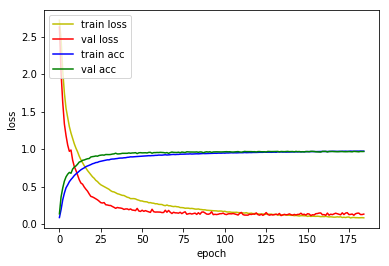

4815/4815 [==============================] - 3s 598us/sample - loss: 0.1752 - acc: 0.9531
Loss: 0.1752099445780211 Accuracy: 0.95306337

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5807 - acc: 0.1458
Epoch 00001: val_loss improved from inf to 2.18212, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_9_conv_checkpoint/001-2.1821.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 2.5807 - acc: 0.1458 - val_loss: 2.1821 - val_acc: 0.2986
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1768 - acc: 0.2863
Epoch 00002: val_loss improved from 2.18212 to 1.84814, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_9_conv_checkpoint/002-1.8481.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 2.1770 - acc: 0.2863 - val_loss: 1.8481 - val_acc: 0.4156
Epoch 3/500
36800/36805 [=================

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2186 - acc: 0.9314
Epoch 00048: val_loss did not improve from 0.16188
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2185 - acc: 0.9314 - val_loss: 0.1629 - val_acc: 0.9511
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2145 - acc: 0.9326
Epoch 00049: val_loss did not improve from 0.16188
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2145 - acc: 0.9326 - val_loss: 0.1663 - val_acc: 0.9485
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2079 - acc: 0.9341
Epoch 00050: val_loss did not improve from 0.16188
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2078 - acc: 0.9341 - val_loss: 0.1772 - val_acc: 0.9495
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2041 - acc: 0.9358
Epoch 00051: val_loss did not improve from 0.16188
36805/36805 [===========

Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0798 - acc: 0.9742
Epoch 00104: val_loss did not improve from 0.13656
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0798 - acc: 0.9742 - val_loss: 0.1617 - val_acc: 0.9595
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0770 - acc: 0.9738
Epoch 00105: val_loss did not improve from 0.13656
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0770 - acc: 0.9738 - val_loss: 0.1446 - val_acc: 0.9639
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0812 - acc: 0.9728
Epoch 00106: val_loss did not improve from 0.13656
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0812 - acc: 0.9728 - val_loss: 0.1751 - val_acc: 0.9604
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0815 - acc: 0.9727
Epoch 00107: val_loss did not improve from 0.13656
36805/36805 [=======

Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9812
Epoch 00134: val_loss did not improve from 0.13656
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0555 - acc: 0.9812 - val_loss: 0.1884 - val_acc: 0.9639
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9820
Epoch 00135: val_loss did not improve from 0.13656
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0557 - acc: 0.9820 - val_loss: 0.1665 - val_acc: 0.9651
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9823
Epoch 00136: val_loss did not improve from 0.13656
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0530 - acc: 0.9823 - val_loss: 0.2141 - val_acc: 0.9623
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0615 - acc: 0.9798
Epoch 00137: val_loss did not improve from 0.13656
36805/36805 [=======

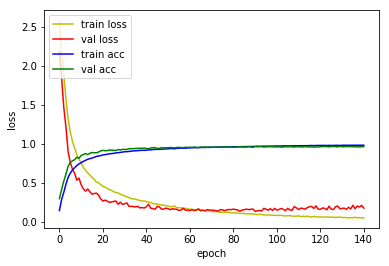

4815/4815 [==============================] - 3s 623us/sample - loss: 0.2159 - acc: 0.9481
Loss: 0.21589078600532913 Accuracy: 0.94807893



In [10]:
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO'
    
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_4_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 32)     

4815/4815 [==============================] - 3s 592us/sample - loss: 0.3019 - acc: 0.9209
Loss: 0.3019223801010247 Accuracy: 0.9208723

1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_124 (Conv1D

4815/4815 [==============================] - 3s 597us/sample - loss: 0.2159 - acc: 0.9481
Loss: 0.21589078600532913 Accuracy: 0.94807893


In [9]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 5333, 32)          3104      
_________________________________________________________________
conv1d_95 (Conv1D)   

4815/4815 [==============================] - 3s 603us/sample - loss: 0.3083 - acc: 0.9205
Loss: 0.3082796956272264 Accuracy: 0.9204569

1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_124 (Conv1D

4815/4815 [==============================] - 3s 657us/sample - loss: 0.2662 - acc: 0.9533
Loss: 0.2662208026789781 Accuracy: 0.95327103
